# Module 3 project

This is SQL database I will be working with in this project

## Northwind Database

<br /><br />
<img src="Northwind_ERD.png" style="width:80%;" alt="Database Schema" />
<br /><br />

# Goal

The goal of this project is to query SQL database to get data needed to perform a statistical analysis. 
In this statistical analysis I will perform a hypothesis test to answer the following questions:

- *Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?*
- *What product sells better Meat or Seafood?*
- *Is there a difference in delivery service ordered for perishable products?*
- *Do perishable products have a different order processing time than non-perishable?*

First import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns 

Now I will transform all SQL tables into Pandas dataframes. This way it will be easier for me to acces and use them.

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cursor = conn.cursor()

In [3]:
table_names = [res[0] for res in cursor.execute('''select name from sqlite_master where type='table';''').fetchall()]
table_names[5] = '[Order]' # Order is an execution name, so we need to put it into square brakets in order not to get errors in future

In [4]:
table_names

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 '[Order]',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [5]:
#create function that makes dataframes

def load_df(table_name=None, conn=None): 
    query = '''select * from {};'''.format(table_name)
    df = pd.read_sql(query, conn)
    return df

In [6]:
#store all dfs in a dictionary

data = {}
for table in table_names:
    data[table] = load_df(table, conn)

In [7]:
#create df for each table

category_df = data['Category']
employee_df = data['Employee']
customer_df = data['Customer']
shipper_df = data['Shipper']
supplier_df = data['Supplier']
order_df = data['[Order]']
product_df = data['Product']
orderdetail_df = data['OrderDetail']
customerCustomerDemo_df = data['CustomerCustomerDemo']
customerDemographic_df = data['CustomerDemographic']
region_df = data['Region']
territory_df = data['Territory']
employeeTerritory_df = data['EmployeeTerritory']

In [8]:
# check if everything is working

order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


First I will create functions that will help me save time through my work.

In [9]:
def visualization(control, experimental):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=25,  label='Experimental', color='r')
    sns.distplot(control, bins=25,  label='Control', color='blue')

    plt.axvline(x=control.mean(), color='blue', linestyle='--')
    plt.axvline(x=experimental.mean(), color='r', linestyle='--')

    plt.title('Control and Experimental Sampling Distributions', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
def Cohen_d(group1, group2): # an effect size used to indicate the standardised difference between two means.

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

def two_tail_ttest(control, experimental, equal_varience=True): # Test I am going to be using through this project
    t_stat, p = stats.ttest_ind(control, experimental, equal_var=equal_varience)
    d = Cohen_d(experimental, control)

    print('p-value', p)
    print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')
    print("Cohen's d:", d)
    

## 1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

- Null Hypothesis = Ho: There is no effect of Discount on the number of products per order.

- Alternative Hypothesis = Ha: There is a positive effect of having a discount and the number of products per order.

In [10]:
orderdetail_df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Company provides all kinds of discounts from 1% to 25%. Let's see if they make any difference in sales.

### Welch's t-test

Welch's t-test provides a more accurate p-value for groups with unequal variances. In my t-test function I will set equal_varience parameter to False.
I am going to use two tailed test because I only need to know if there is a significant difference between two means. I would use one tail test if I needed to know if one mean is significantly larger or smaller than the other.


For two tailed test **Alpha** level is set to **0.025 or 0.25%**

In [11]:
# create control and experimental groups

no_disc = orderdetail_df[orderdetail_df['Discount'] == 0]['Quantity']
disc = orderdetail_df[orderdetail_df['Discount'] != 0]['Quantity'] 

p-value 5.65641429030433e-10
Reject Null Hypothesis
Cohen's d: 0.2862724481729283


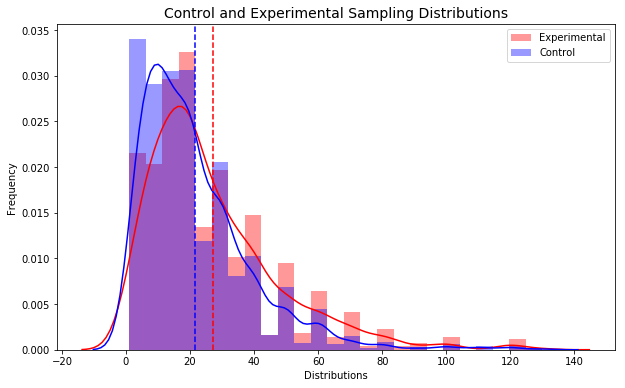

In [12]:
two_tail_ttest(no_disc, disc, equal_varience=False)
visualization(no_disc, disc)

P-value is smaller than alpha so we can safely **reject Null hypothesis**. On the plot we can clearly see that discounted products sell better. Now I will find out at what point discount starts making an impact.

In [13]:
discounts_significance_df = pd.DataFrame(columns=['Discount %','Null Hypothesis','Cohens d'], index=None) 
#create dataframe to store results

discounts = [0.05, 0.1, 0.15, 0.2, 0.25] # there are only 8 orders with discount from 1, 2, 3, 4 and 6% so I won't include them in my test

control = orderdetail_df[orderdetail_df['Discount'] == 0]['Quantity']
for i in discounts:
    experimental = orderdetail_df[orderdetail_df['Discount'] == i]['Quantity']
    st, p = stats.ttest_ind(control, experimental, equal_var=False)
    d = Cohen_d(experimental, control)
    discounts_significance_df = discounts_significance_df.append( { 'Discount %' : str(i*100)+'%' , 'Null Hypothesis' : 'Reject' if p < 0.025 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discounts_significance_df

,Discount %,Null Hypothesis,Cohens d
0,5.0%,Reject,0.346877
1,10.0%,Failed,0.195942
2,15.0%,Reject,0.372404
3,20.0%,Reject,0.300712
4,25.0%,Reject,0.366593


**Results show that discounts of 5%, 15%, 20% and 25% are statistically significant with 15% discount being most effective as it has largest effect size**

# 2. What sells better Meat or Seafood?

- Null Hypothesis = Ho: There is no significant difference in average order price between Meat and Seafood

- Alternative Hypothesis = Ha: There is a difference in average order price between Meat and Seafood

Meat and seafood are two most expensive products. I am going to find out which of them brings more money. This can give an insight in which category this company specializes.

In [14]:
category_df 

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


In [15]:
# query sql for all currect orders with total order price
orders_total = pd.read_sql_query("""SELECT OrderDetail.OrderId, CategoryId, OrderDetail.UnitPrice*Quantity-OrderDetail.UnitPrice*Discount AS TOTAL 
                  FROM OrderDetail
                  JOIN Product on OrderDetail.ProductId = Product.Id
                  ;""", conn)
orders_total.head(5)

,OrderId,CategoryId,TOTAL
0,10248,4,168.0
1,10248,5,98.0
2,10248,4,174.0
3,10249,7,167.4
4,10249,7,1696.0


In [16]:
#create our groups for comparison
seafood = orders_total[orders_total['CategoryId'] == 8]['TOTAL']
meat = orders_total[orders_total['CategoryId'] == 6]['TOTAL']

In [17]:
seafood.describe()

count     330.000000
mean      427.922348
std       462.944568
min         4.800000
25%       119.175000
50%       297.000000
75%       554.175000
max      3125.000000
Name: TOTAL, dtype: float64

In [18]:
meat.describe()

count     173.000000
mean     1027.203827
std      1440.980290
min        20.860000
25%       223.500000
50%       504.000000
75%      1287.000000
max      9903.200000
Name: TOTAL, dtype: float64

In [19]:
two_tail_ttest(seafood, meat, equal_varience=False)

p-value 2.782775086500259e-07
Reject Null Hypothesis
Cohen's d: 0.6481981410922895


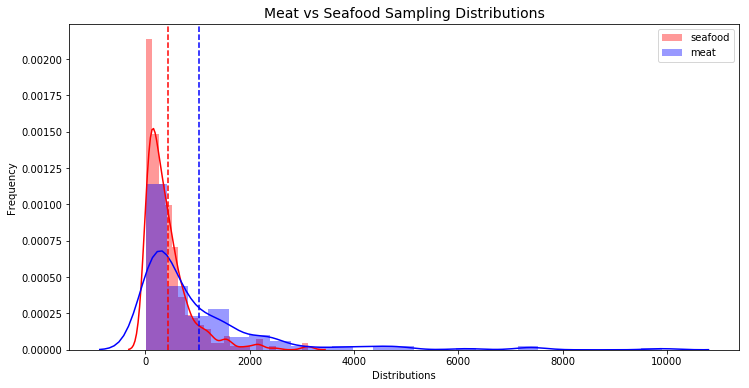

In [20]:
plt.figure(figsize=(12,6))
sns.distplot(seafood, bins=25,  label='seafood', color='r')
sns.distplot(meat, bins=25,  label='meat', color='blue')

plt.axvline(x=meat.mean(), color='blue', linestyle='--')
plt.axvline(x=seafood.mean(), color='r', linestyle='--')

plt.title('Meat vs Seafood Sampling Distributions', fontsize=14)
plt.xlabel('Distributions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Even though seafood sells more often meat comes in much bigger orders making a significant difference in sales**

# 3 Is there a difference in delivery service ordered for perishable products?

Null Hypothesis = Ho: There is no difference in delivery service ordered for perishable and non-perishable products.

Alternative Hypothesis = Ha: There is a difference in delivery service ordered for perishable and non-perishable products.

In this test I want to find out if customers use a certain delivery service for certain products. For example I can assume that customers will use express delivery more often for perishable products. 

In [21]:
shipper_df # check what delivery services are available

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [22]:
# find all current orders with categories and delivery services
ship_service = pd.read_sql_query("""SELECT ProductName, CategoryId, Freight, ShipVia, ShipCountry  
                  FROM OrderDetail
                  JOIN Product on OrderDetail.ProductId = Product.Id
                  JOIN [Order] on OrderDetail.OrderId = [Order].Id
                  ;""", conn)
ship_service.head()

,ProductName,CategoryId,Freight,ShipVia,ShipCountry
0,Queso Cabrales,4,32.38,3,France
1,Singaporean Hokkien Fried Mee,5,32.38,3,France
2,Mozzarella di Giovanni,4,32.38,3,France
3,Tofu,7,11.61,1,Germany
4,Manjimup Dried Apples,7,11.61,1,Germany


Based on the description below I consider categories 4, 6, 8 to be perishable and the rest non-perishable. I will divide them into two groups and compare delivery services ordered.

In [23]:
category_df 

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


In [24]:
non_perishable = ship_service[ship_service.CategoryId.isin([1, 2, 3, 5, 7])]['ShipVia']
perishable = ship_service[ship_service.CategoryId.isin([4, 6, 8])]['ShipVia']

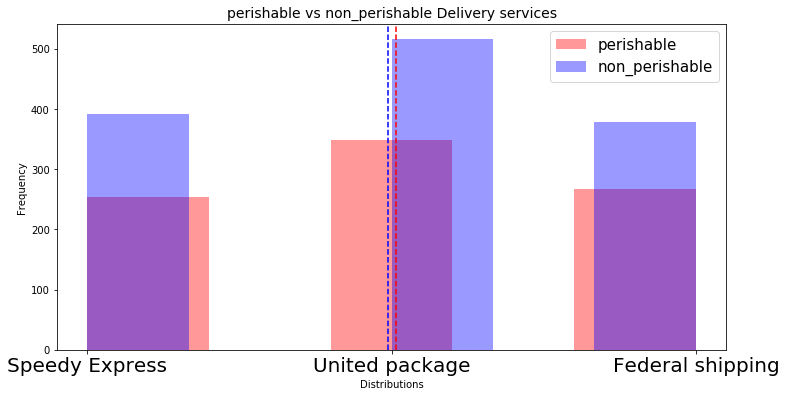

In [51]:
plt.figure(figsize=(12,6))
sns.distplot(perishable,  kde=False, label='perishable', color='r')
sns.distplot(non_perishable,  kde=False, label='non_perishable', color='blue')

plt.axvline(x=non_perishable.mean(), color='blue', linestyle='--')
plt.axvline(x=perishable.mean(), color='r', linestyle='--')

plt.title('perishable vs non_perishable Delivery services', fontsize=14)
plt.xlabel('Distributions')
plt.ylabel('Frequency')
objects = ('Speedy Express', 'United package', 'Federal shipping')
y_pos = np.arange(1, 4, step=1)
plt.xticks(y_pos, objects, fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [26]:
two_tail_ttest(non_perishable, perishable)

p-value 0.44722590665893913
Failed to reject Null Hypothesis
Cohen's d: 0.033382112020631495


Based on the t-test and visualization we can come to conclusion that there is no significant difference in delivery service ordered for perishable and non-perishable products.
** Therefore we Fail to reject Null Hypothesis**

# 4. Do perishable products have a different order processing time than non-perishable

Null Hypothesis = Ho: There is no difference in processing time for perishable and non-perishable products.

Alternative Hypothesis = Ha: Perishable products have a different processing time than non-perishable

In [27]:
order_process = pd.read_sql_query("""SELECT CategoryId, Freight, ShipVia, OrderDate, ShippedDate   
                  FROM OrderDetail
                  JOIN Product on OrderDetail.ProductId = Product.Id
                  JOIN [Order] on OrderDetail.OrderId = [Order].Id
                  ;""", conn)

In [28]:
order_process.OrderDate = pd.to_datetime(order_process.OrderDate) #convert to datetime 
order_process.ShippedDate = pd.to_datetime(order_process.ShippedDate)
order_process['Process_time'] = order_process.ShippedDate - order_process.OrderDate #calculate processing time in days
order_process.Process_time = order_process.Process_time.dt.days #returns a numpy array containing the day of the datetime

In [29]:
order_process.head()

,CategoryId,Freight,ShipVia,OrderDate,ShippedDate,Process_time
0,4,32.38,3,2012-07-04,2012-07-16,12.0
1,5,32.38,3,2012-07-04,2012-07-16,12.0
2,4,32.38,3,2012-07-04,2012-07-16,12.0
3,7,11.61,1,2012-07-05,2012-07-10,5.0
4,7,11.61,1,2012-07-05,2012-07-10,5.0


In [30]:
order_process.dropna(inplace=True) #drop columns with Nan values
order_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 2110
Data columns (total 6 columns):
CategoryId      2082 non-null int64
Freight         2082 non-null float64
ShipVia         2082 non-null int64
OrderDate       2082 non-null datetime64[ns]
ShippedDate     2082 non-null datetime64[ns]
Process_time    2082 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 113.9 KB


In [31]:
non_perish_process = order_process[order_process.CategoryId.isin([1, 2, 3, 5, 7])]['Process_time']
perish_process = order_process[order_process.CategoryId.isin([4, 6, 8])]['Process_time']


In [32]:
two_tail_ttest(non_perish_process, perish_process)

p-value 0.23747290917462607
Failed to reject Null Hypothesis
Cohen's d: 0.052757800506166755


Surprisingly the average processing time for both products is the roughly same and test shows that there is no significant difference between them.
**So we Fail to reject Null hypothesis**

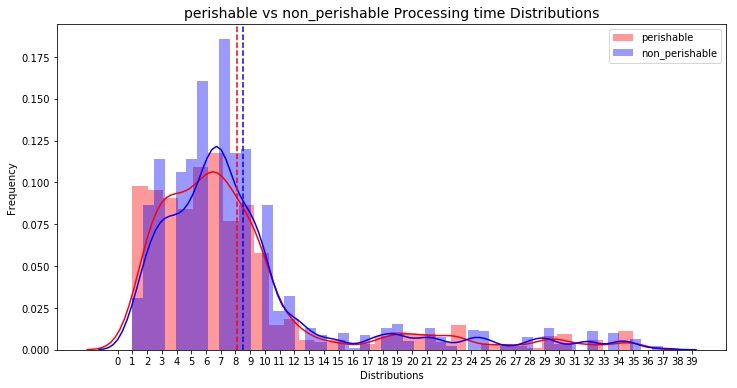

In [33]:
plt.figure(figsize=(12,6))
sns.distplot(perish_process, label='perishable', color='r')
sns.distplot(non_perish_process, label='non_perishable', color='blue')

plt.axvline(x=non_perish_process.mean(), color='blue', linestyle='--')
plt.axvline(x=perish_process.mean(), color='r', linestyle='--')

plt.title('perishable vs non_perishable Processing time Distributions', fontsize=14)
plt.xlabel('Distributions')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 40, step=1))
plt.legend()
plt.show()

## Conclusion

1. Discounts of 5%, 15%, 20% and 25% have significant effect on order quantity with 15% being most effective.

2. Seafood sells more often but meat comes in much bigger orders making a significant difference in sales.

3. There is no significant difference in delivery service ordered for perishable and non-perishable products. 

4. Product category does not affect order processing time

## Further steps

Investigate further the impact of discount on different product categories

Seafood seems to be a more popular choice than meat. Applying discounts on certain products could increase sales and overall profit.

Find out if shipping and processing times affects the quality of delivered products. If they do then give discounts on express delivery services for large orders. This way we stimulate larger sales and improve quality of the product.